We are trying to solve <br>
$\frac{\partial u}{\partial x} = A\frac{\partial^{2} u}{\partial z^{2}} + F(x,z)u$<br><br>
Using Crank Nicolson, this becomes (eq 3.15, [Fuhse thesis](https://ediss.uni-goettingen.de/bitstream/handle/11858/00-1735-0000-0006-B592-3/fuhse.pdf?sequence=1%20fuhse%20thesis)) : <br>
$B^{n}u^{n+1} = d^{n}$ <br>
where, $u^{n}$ denotes the wave at the nth plane, $B^{n}$ is an n by n tridiagonal matrix, and $d^{n}$ is related to $u^{n}$<br><br>
Define: <br>
$r_{z} = A\frac{\Delta x}{\Delta z^{2}}$<br>
$C^{n+\frac{1}{2}}_{k} = \frac{F^{n+\frac{1}{2}}_{k}\Delta x}{2}$<br>
$A = \frac{-i}{2k}$<br>
$F(x,y,z) = -1*\frac{ik}{2}(n^{2}(x,y,z)-1)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib
from skimage.restoration import unwrap_phase
from scipy.signal import gaussian
from xwp.finite_diff_1d import finite_diff_1d_matter
np.set_printoptions(2)

In [2]:
def get_property(mat,energy):
    url = "http://henke.lbl.gov/cgi-bin/pert_cgi.pl"
    data = {'Element':str(mat), 'Energy':str(energy), 'submit':'Submit Query'}
    data = urllib.parse.urlencode(data)
    data = data.encode('utf-8')
    req = urllib.request.Request(url, data)
    resp = urllib.request.urlopen(req)
    respDat = resp.read()
    response = respDat.split()
    d =  b'g/cm^3<li>Delta'
    i = response.index(d)
    delta = str(response[i+2])[:str(response[i+2]).index('<li>Beta')][2:]
    beta = str(response[i+4])[2:-1]
    return float(delta),float(beta)

*get_property* : gets delta and beta for a given material at the specified energy from Henke et al.
* *Inputs* : mat - material, energy - energy in eV
* *Outputs* : delta, beta

In [3]:
π = np.pi
E = 10000
λ = (1239.84/E)*1e-9
k = ((2*π)/λ)
A = -1j/(2*k)
n_au = 1 - get_property('Au',E)[0] - 1j*get_property('Au',E)[1]

In [4]:
dim_x = 5000
dim_z = 5000
z = np.linspace(-2e-6,5e-6,dim_z)
x = np.linspace(0,1000e-6,dim_x)
Δx = x[1] - x[0]
Δz = z[1] - z[0]
X,Z = np.meshgrid(x,z)
r_z = A * (Δx/(Δz)**2) 
coords = [x[0]*1e6,x[-1]*1e6,z[0]*1e6,z[-1]*1e6]

In [5]:
c = -2e-6
m = np.tan(4e-3)
loc_mat = np.where(Z<(m*X+c)) #location of material.

In [6]:
F = np.zeros(np.shape(X),dtype=np.complex128)
F[loc_mat] = -1j*(k/2)*(n_au**2-1)

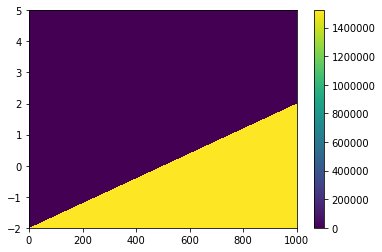

In [7]:
plt.imshow(np.abs(F),origin='lower',aspect='auto',extent=coords)
plt.colorbar()
plt.show()

In [8]:
C = (F*(Δx/2))
#for i in range(dim_x-2):
#    C[i+1] = (C[i+1]+C[i+2])/2

In [9]:
#wave = np.array(gaussian(dim_z,100),dtype=np.complex128)
wave = np.zeros(dim_z,dtype=np.complex128)
loc_wave = np.where(np.logical_and(z<1e-6,z>-1e-6))
wave[loc_wave] = 1
#θ = 4e-3
#loc_wave = np.where(wave!=0)
#slope = np.exp(1j*2*np.pi*(1/λ)*np.tan(θ)*z[loc_wave])
#wave[loc_wave] = wave[loc_wave]*slope
d = np.zeros(dim_z-2,dtype=np.complex128)
wave_history = np.zeros((dim_z,dim_x),dtype=np.complex128)

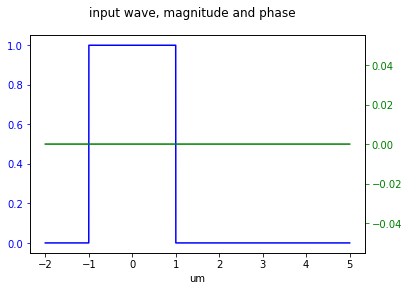

In [10]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(z*1e6,np.abs(wave),'b')
ax2.plot(z*1e6,unwrap_phase(np.angle(wave)),'g')
fig.suptitle('input wave, magnitude and phase')
ax1.set_xlabel('um')
ax1.tick_params('y', colors='b')
ax2.tick_params('y', colors='g')
plt.show()

In [11]:
from scipy.sparse import diags
import scipy.sparse.linalg as splinalg
from tqdm import trange
def finite_diff_1d_matter(dim_x,dim_z,r_z,C,wave,wave_history):
    for i in trange(dim_x):
        c = C[1:-1,i] + np.ones(dim_z-2)*(1-r_z)
        d = c*wave[1:-1] + 0.5*r_z*wave[2:] + 0.5*r_z*wave[:-2]
        d[0]  += r_z*wave[0]
        d[-1] += r_z*wave[-1]
        b_diag = np.ones(dim_z-2)*(1 + r_z) - C[1:-1,i]
        B = diags(b_diag,offsets=0) +\
            diags(-r_z/2*np.ones(dim_z-3),offsets=1) +\
            diags(-r_z/2*np.ones(dim_z-3),offsets=-1)
        wave[1:-1] = splinalg.spsolve(B,d)
        wave_history[1:-1,i] = wave[1:-1]

In [12]:
finite_diff_1d_matter(dim_x,dim_z,r_z,C,wave,wave_history)

100%|██████████| 5000/5000 [00:27<00:00, 183.70it/s]


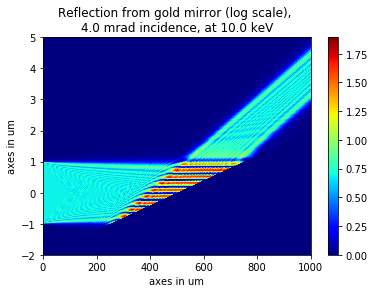

In [13]:
plt.imshow(np.log(np.abs(wave_history[:,:])**2+1),origin='lower',aspect='auto',extent=coords,cmap='jet')
plt.colorbar()
plt.xlabel('axes in um')
plt.ylabel('axes in um')
plt.title('Reflection from gold mirror (log scale), '+'\n'+str(round(m*1e3,3))+' mrad incidence, at '+str(round(E*1e-3,3))+' keV')
plt.rcParams["figure.figsize"] = (8,8)
plt.show()

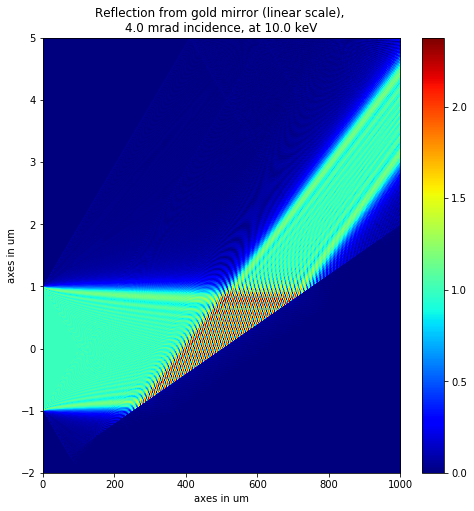

In [14]:
plt.imshow(np.abs(wave_history[:,:]),origin='lower',aspect='auto',extent=coords,cmap='jet')
plt.colorbar()
plt.xlabel('axes in um')
plt.ylabel('axes in um')
plt.title('Reflection from gold mirror (linear scale), '+'\n'+str(round(m*1e3,3))+' mrad incidence, at '+str(round(E*1e-3,3))+' keV')
plt.rcParams["figure.figsize"] = (8,8)
plt.show()

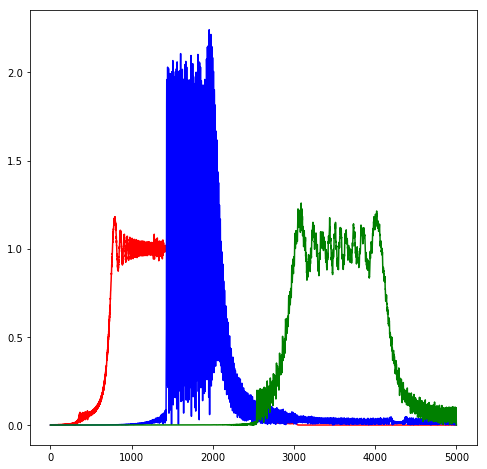

In [15]:
plt.plot(np.abs(wave_history[:,int(dim_x/8)]),'r')
plt.plot(np.abs(wave_history[:,int(dim_x/2)]),'b')
plt.plot(np.abs(wave_history[:,int(dim_x*8/9)]),'g')
plt.show()

1.4002800560111745e-09